# Coordinate frame conversions

Here are the most prominently-featured sources of documentation on the subject:

*   https://casa.nrao.edu/casadocs/latest/memo-series/reference-material/spectral-frames
*   https://help.almascience.org/index.php?/Knowledgebase/Article/View/86
*   https://casa.nrao.edu/docs/TaskRef/mstransform-task.html
*   https://casa.nrao.edu/casadocs/latest/calibration-and-visibility-data/uv-manipulation/manipulating-visibilities-with-mstransform
*   https://casa.nrao.edu/docs/TaskRef/cvel-task.html
*   http://www.gb.nrao.edu/~fghigo/gbtdoc/doppler.html



The goal of this notebook is to demonstrate conversion of visibility and image data converted between spectral, spatial, and temporal reference frames using the next generation CASA infrastructure.

# Setting up


In [1]:
import os, time

start = time.time()
print("Installing fortran and CASA6 dependencies")
os.system("apt-get install libgfortran3")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
print(f"completed after {round(time.time() - start, 2)} seconds")
print("Installing ZINC")
os.system("pip install cngi-prototype==0.0.36")
print(f"completed after {round(time.time() - start, 2)} seconds")

Installing fortran and CASA6 dependencies
completed after 115.84 seconds
Installing ZINC
completed after 217.83 seconds


In [0]:
import numpy as np
import xarray as xr
import zarr
import cngi.dio
import cngi.vis
import cngi.image
from graphviz import Digraph

Note that we have not completely installed CASA6, so no tasks are available for use in this notebook.

## Data access

We don't need to download or convert any data if we use what's been previously converted and made available for download. We're going to accomplish that through the use of Simple Storage Service (S3) provided by Amazon Web Services.

This service provides a means of uploading and storing arbitrary data in the form of objects, accessible via web interface. `boto3` is the SDK provided by AWS to manage authentication and object access/manipulation.

In [0]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

This library allows us to register an object bucket in S3 with our python process as if it were a file system. This can be convenient for certain operations, and will allow us to treat the remotely-stored object data as if they were locally hosted file data.


In [4]:
# Specify AWS S3 path
bucket = 'cngi-prototype-test-data/'

#ous, ddi = 'uid___A002_Xcad526_X4b6e', '27/'
#ous, ddi = 'uid___A002_Xcbc47c_Xe556', '5/'
ous, ddi = 'uid___A002_Xcfc232_X2eda', '16/'

dimension = 'chan'
#dimension = 'time'

contents = s3.listdir(bucket+ous+'_'+dimension+'_chunks.vis.zarr/'+ddi)
exists = s3.isdir(bucket+ous+'_'+dimension+'_chunks.vis.zarr/global/')

print(f"It is {exists} that these data can be accessed like files")
print(f"Here is an example object: {contents[0]}")

It is True that these data can be accessed like files
Here is an example object: {'Key': 'cngi-prototype-test-data/uid___A002_Xcfc232_X2eda_chan_chunks.vis.zarr/16/.zattrs', 'LastModified': datetime.datetime(2020, 1, 29, 18, 51, 20, tzinfo=tzlocal()), 'ETag': '"8e8e8993b89675494f89a2f7536106e1"', 'Size': 495, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 495, 'name': 'cngi-prototype-test-data/uid___A002_Xcfc232_X2eda_chan_chunks.vis.zarr/16/.zattrs'}


Most of the objects we have uploaded to this bucket (so far) are zarr groups. [Zarr](https://zarr.readthedocs.io/en/stable/index.html) has been identified as a promising candidate library for managing the I/O component of our infrastructure in part because it was designed with features that allow it to reliably serve as a self-documenting, cloud-optimized array storage format. Access to this library's methods is exposed via the python standard libary's [MutableMapping](https://docs.python.org/3/library/collections.abc.html#collections.abc.MutableMapping) interface.

Let's open a zarr file that contains some calibrated visibility data.

In [0]:
s3_path = bucket+'test_data/sis14_twhya_field5_mstrans_lsrk.vis.zarr/'
ddi = "0"
s3_vis = s3_path+ddi
s3_md = s3_path+"global"

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_md = s3fs.S3Map(root=s3_md, s3=s3, check=False)

In [7]:
# We haven't opened anything, just created a big container of key-value pairs
print(store_md)

In [0]:
# Now we actually pass the mappings as input to xarray's zarr interface
vis_xds = xr.open_zarr(store=store_vis, consolidated=False)
global_xds = xr.open_zarr(store=store_md, consolidated=False)

And just like that we have a lazily-evaluated representation of our visibility group, which we can represent as an xarray *Dataset*.

We also have image data on S3 that were produced using the ngCASA gridder. Let's get those too.

In [0]:
s3_img = bucket+'test_data/cube_twhya_standard_gridder.img.zarr/'

# Convert object stores to our desired MutableMapping interface
store_img = s3fs.S3Map(root=s3_img, s3=s3, check=False)
img_xds = xr.open_zarr(store=store_img, consolidated=False)

#### To do

Extend cngi.dio.read_vis and cngi.dio.read_image to recognize s3 URLs and open up fsspec.mapping.FSMap objects, ideally handling this for us under the covers.

# Coordinate transformation

Apart from data selection criteria, it is important to understand the key parameters of transformation from the terrestrial reference frame in which telescopes [such as ALMA](https://help.almascience.org/index.php?/Knowledgebase/Article/View/86) record their observations. 

The local observatory frame, with a fixed observing frequency (no Doppler tracking) is defined as the topocentric reference frame, TOPO.**bold text**

## Visibility data

### astropy

Various spectral reference frames are currently supported by astronomical software libraries, including [Astropy](https://docs.astropy.org/en/stable/coordinates/index.html#class-inheritance-diagram) and [CASA](https://casa.nrao.edu/casadocs/latest/memo-series/reference-material/spectral-frames).

astropy adopts a standard definition of the LSR following [Schönrich et al. 2010](https://ui.adsabs.harvard.edu/abs/2010MNRAS.403.1829S/abstract):

> The LSR is the rest frame at the location of the Sun of a star that would be on a circular orbit in the gravitational potential one would obtain by azimuthally averaging away non-axisymmetric features in the actual Galactic potential.

###### To do
*   Open issue/PR on astropy to get the broken links from their class inheritance diagram fixed
*   Determine mathematical conventions for all relevant spectral, spatial, temporal transformations for comparison and adaption

### casa(core)

CASA differentiates between the Dynamical and Kinematic LSR following the conventions of [Delhaye, 1965](https://ui.adsabs.harvard.edu/abs/1965gast.book...61D/abstract) and [Gordon, 1975](https://www.sciencedirect.com/science/article/pii/S0076695X08607139) respectively.

> Dynamical LSR: Solar peculiar velocity with respect to a frame in circular motion about the galactic center

> Kinematic LSR:  Conventional Local Standard of Rest based on average velocity of stars in the Solar neighborhood 

Conversions (API functions) and Frames (Epoch, Position, Direction) 

##### To do

There is a sequence of conversions that has to happen. Go to the relevant MC[Frame].cc file in casacore and find the doconvert method

In [0]:
from graphviz import Digraph

In [0]:
dot = Digraph(filename="digraph.png")

dot.edge("measures","epoch")
dot.edge("measures","direction")
dot.edge("measures","position")
dot.edge("measures","frequency")
dot.edge("measures","radial velocity")
dot.edge("measures","baseline")
dot.edge("measures","visibility coordinate (uvw)")

dot.edge("epoch","quantity")
dot.edge("frequency","quantity")
dot.edge("radial velocity","quantity")
dot.edge("baseline","quantity")
dot.edge("direction","quantity")
dot.edge("position","quantity")
dot.edge("visibility coordinate (uvw)","quantity")

dot.edge("epoch","frame")
dot.edge("frequency","frame")
dot.edge("radial velocity","frame")
dot.edge("baseline","frame")
dot.edge("direction","frame")
dot.edge("position","frame")
dot.edge("visibility coordinate (uvw)","frame")

dot.edge("epoch","reference code")
dot.edge("frequency","reference code")
dot.edge("radial velocity","reference code")
dot.edge("baseline","reference code")
dot.edge("direction","reference code")
dot.edge("position","reference code")
dot.edge("visibility coordinate (uvw)","reference code")

dot.edge("quantity", "time")
dot.edge("quantity", "spectroscopy")
dot.edge("quantity", "angle")
dot.edge("quantity", "direction")
dot.edge("quantity", "position")

dot.edge("frame", 'where am I?')
dot.edge("frame", 'what direction?')
dot.edge("frame", 'when is it?')
dot.edge("frame", 'how fast?')

#dot.edge("reference code", "direction")
direction_codes = 'J2000 JMEAN-epoch JTRUE-epoch APP-epoch B1950 BMEAN-epoch BTRUE-epoch GALACTIC HADEC-epoch,position AZEL-epoch,position SUPERGALACTIC ECLIPTIC MECLIPTIC-epoch TECLIPTIC-epoch PLANET-epoch,[position]'
for code in direction_codes.split(' '):
  dot.edge("reference code", code)

#dot.edge("reference code", "position")
dot.edge("reference code", "ITRF")
dot.edge("reference code", "WGS84")

#dot.edge("reference code", "epoch")
epoch_codes = 'UTC TAI LAST-position LMST-position GMST1 GAST UT1 UT2 TDT TCG TDB TCD'
for code in epoch_codes.split(' '):
  dot.edge('reference code', code)

#dot.edge("reference code", "radial velocity")
radial_codes = 'LSRK-direction LSRD-direction BARY-direction GEO-direction,epoch TOPO-direction,epoch,position GALACTO-direction'
for code in radial_codes.split(' '):
  dot.edge('reference code', code)

#dot.edge("reference code", "doppler")
#doppler_codes = 'RADIO OPTICAL Z RATIO RELATIVISTIC BETA GAMMA'
#for code in doppler_codes.split(' '):
#  dot.edge('reference', code)

#dot.edge("reference code", "frequency")
frequency_codes = 'REST-direction,radialvelocity LSRK-direction LSRD-direction BARY-direction GEO-direction,epoch TOPO-direction,epoch,position GALACTO'
for code in frequency_codes.split(' '):
  dot.edge('reference code', code)


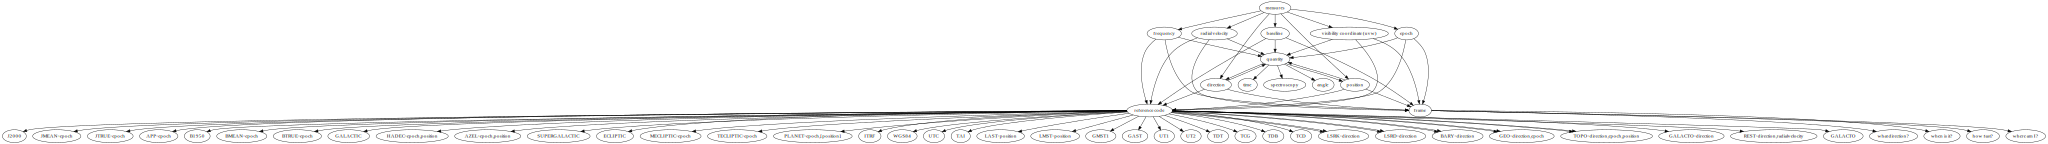

In [13]:
dot

### ZINC

MutableMapping corresponds to all the coordinate transformations



In [0]:
import cngi.vis
import cngi.image

In [15]:
print(vis_xds)

<xarray.Dataset>
Dimensions:        (baseline: 210, chan: 384, pair: 2, pol: 2, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan           (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width     (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    field          (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol            (pol) int32 9 12
    processor      (time) <U14 dask.array<chunksize=(270,), meta=np.ndarray>
    resolution     (ch

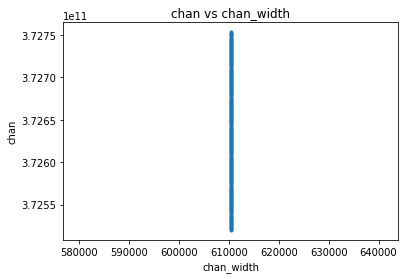

In [16]:
cngi.vis.visualize(vis_xds.chan, 'chan_width')

In [0]:
#vis_xds.attrs['unit_map':{}]

We also have access to the global properties of the observation

In [18]:
print(global_xds)

<xarray.Dataset>
Dimensions:                 (antenna: 26, d1: 1, d2: 2, d3: 3, feed: 1, field: 1, observation: 1, processor: 3, receptors: 3, source: 1, spw: 1, state: 20, time_fcmd: 5067, time_hist: 1137)
Coordinates:
  * antenna                 (antenna) int64 0 1 2 3 4 5 6 ... 20 21 22 23 24 25
  * feed                    (feed) int64 0
  * field                   (field) <U6 'TW Hya'
  * observation             (observation) <U22 'uid://A002/X327408/X6f'
  * processor               (processor) <U14 'CORRELATOR (0)' ... 'CORRELATOR (2)'
  * receptors               (receptors) int64 0 1 2
  * source                  (source) int32 0
  * spw                     (spw) int64 0
  * state                   (state) <U82 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (0)' ... 'OBSERVE_TARGET#ON_SOURCE (19)'
  * time_fcmd               (time_fcmd) float64 4.86e+09 4.86e+09 ... 4.86e+09
  * time_hist               (time_hist) float64 4.861e+09 ... 5.077e+09
D

In [19]:
print(global_xds.ANT_POSITION.values)

[[ 2225083.64619763 -5440070.40606462 -2481658.02670859]
 [ 2225079.88001574 -5440041.3775342  -2481724.59803141]
 [ 2224981.09778387 -5440131.25038739 -2481621.0663739 ]
 [ 2225193.4501669  -5439993.76415663 -2481722.5405336 ]
 [ 2225181.07053168 -5440026.29079042 -2481662.97510257]
 [ 2225060.20258009 -5440050.34443573 -2481722.59865136]
 [ 2225044.23958335 -5440102.02253539 -2481624.80840452]
 [ 2225032.05165178 -5440052.42601493 -2481745.66000331]
 [ 2225069.89852632 -5440066.75927329 -2481676.9364416 ]
 [ 2225255.25927201 -5440008.98786919 -2481623.35205242]
 [ 2225094.62284094 -5440051.99359209 -2481687.08159262]
 [ 2225287.59376558 -5439952.24367855 -2481718.60531402]
 [ 2225048.72928734 -5440061.08577674 -2481708.13913597]
 [ 2225119.37502846 -5440042.84999607 -2481684.9435547 ]
 [ 2225063.81471469 -5440077.94826116 -2481657.99257155]
 [ 2225011.14194474 -5440147.56093196 -2481557.85566338]
 [ 2225199.25437472 -5440058.16149446 -2481571.80369891]
 [ 2225176.48351397 -5439963.82

In [20]:
print(global_xds.SRC_DIRECTION)

<xarray.DataArray 'SRC_DIRECTION' (spw: 1, source: 1, d2: 2)>
dask.array<zarr, shape=(1, 1, 2), dtype=float64, chunksize=(1, 1, 2), chunktype=numpy.ndarray>
Coordinates:
  * source   (source) int32 0
  * spw      (spw) int64 0
Dimensions without coordinates: d2


In [21]:
np.unique(np.asarray(global_xds.ASDM_startValidTime))

array([4.86002698e+09, 4.86002712e+09, 4.86002730e+09, 4.86002739e+09,
       4.86002761e+09, 4.86002778e+09, 4.86002786e+09, 4.86002808e+09,
       4.86002826e+09, 4.86002834e+09, 4.86002848e+09, 4.86002898e+09,
       4.86002905e+09, 4.86002919e+09, 4.86002969e+09, 4.86002976e+09,
       4.86002990e+09, 4.86003039e+09, 4.86003047e+09, 4.86003062e+09,
       4.86003112e+09, 4.86003119e+09, 4.86003133e+09, 4.86003182e+09,
       4.86003189e+09, 4.86003203e+09, 4.86003219e+09])

## Image data

#### astropy

There are [official demos](http://learn.astropy.org/rst-tutorials/Coordinates-Transform.html) from astropy. This is an adaption to show how the concepts work for comparison with our other methods.

In [0]:
from astropy import units as u
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import AltAz

The units module allows us to create quanity objects for unit-aware computing.

In [23]:
VLA_lat = 34.1*u.degree
VLA_lon = -107.6*u.degree
VLA_alt = 2114.89*u.m
print((VLA_lat, VLA_lon, VLA_alt))

(<Quantity 34.1 deg>, <Quantity -107.6 deg>, <Quantity 2114.89 m>)


The coordinates module allows for straightforward conversion of quantities between the references frames in which they are represented.

In [24]:
observing_location = EarthLocation(lat=VLA_lat, 
                                   lon=VLA_lon, 
                                   height=VLA_alt,
                                   ellipsoid='WGS84')
print(observing_location, type(observing_location))

(-1599173.52082635, -5041233.67723585, 3556822.79344969) m <class 'astropy.coordinates.earth.EarthLocation'>


In [25]:
reference_time = Time(['2019-10-4T00:00:00'], 
                        format='isot',
                        scale='utc', 
                        location=observing_location)
print(reference_time, type(reference_time))

['2019-10-04T00:00:00.000'] <class 'astropy.time.core.Time'>


In [26]:
phase_center = SkyCoord(ra='19h59m28.5s', dec='+40d44m01.5s', frame='fk5')
print(phase_center)

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (299.86875, 40.73375)>


Since we can define locations, coordinates on the celestial sphere, and times, we can transform between these quantities.

In [27]:
alt_az_frame = AltAz(location=observing_location, obstime=reference_time)
print(alt_az_frame)
new_frame = phase_center.transform_to(alt_az_frame)

<AltAz Frame (obstime=['2019-10-04T00:00:00.000'], location=(-1599173.52082635, -5041233.67723585, 3556822.79344969) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>


In [28]:
# Converting the results between different units is as simple as
print((new_frame.az.radian,
       new_frame.alt.radian),
      "and",
      (new_frame.az.degree, 
       new_frame.alt.degree))

(array([1.1522305]), array([1.07222892])) and (array([66.01794453]), array([61.43419156]))


We should ensure we are making use of the [higher-precision mode](https://docs.astropy.org/en/latest/coordinates/velocities.html#precision-of-radial-velocity-correction) when we implement radial velocity (and possibly all) corrections.

#### casa(core)

In [0]:
from casatools import measures

In [30]:
me = measures()
    
observing_location = me.position('WGS84', '-107.6deg','34.1deg', '2114.89m')
me.doframe(observing_location)
print(observing_location)

{'m0': {'unit': 'rad', 'value': -1.8779742751458985}, 'm1': {'unit': 'rad', 'value': 0.5951572749300664}, 'm2': {'unit': 'm', 'value': 2114.89}, 'refer': 'WGS84', 'type': 'position'}


In [31]:
# For comparison, astropy reports
[dim.to(u.radian) for dim in (VLA_lat, VLA_lon, VLA_alt) if dim.unit == 'deg']

[<Quantity 0.59515727 rad>, <Quantity -1.87797428 rad>]

In [32]:
#set frame reference_time (epoch)
reference_time = me.epoch('utc', '2019/10/4/0h0m00')
me.doframe(reference_time)

True

In [0]:
#Phase Center
phase_center = me.direction('J2000', '19h59m28.5', '40d44m01.5')

This result is pretty close to what astropy reports, but the representation and interface are clearly different.

In [34]:
# Convert phase center to a new reference frame
azelgeo=me.measure(phase_center, 'AZELGEO')
print(azelgeo)
#print(azelgeo['m0']['value'],azelgeo['m1']['value'])

{'m0': {'unit': 'rad', 'value': 1.1522291424864282}, 'm1': {'unit': 'rad', 'value': 1.0722309775454635}, 'refer': 'AZELGEO', 'type': 'direction'}


#### ZINC

With the next-gen infrastructure for CASA, our fundamental intermediate representation for data access and manipulation is the [xarray _Dataset_](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html). Since at their core, these are just collections of [_DataArray_](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray) objects which are essentially composed of `ndarray` objects, our data type is compatible with inputs to both unit and frame conversion methods - so long as we drop the relevant arrays out of our lazily-evaluated paradigm and into memory so that we can eagerly wrap them in the appropriate subclass.

Ideally, we wouldn't have to do this. Xarray developers are actually already working on implementing a protocol that would allow us to access unit-aware computation directly through the xarray interface, by wrapping [pint](https://pint.readthedocs.io/en/latest/) Quantity objects around [dask arrays](https://docs.dask.org/en/latest/array.html) (see [NEP 18](https://numpy.org/neps/nep-0018-array-function-protocol.html) and [xarray GH#3594](https://github.com/pydata/xarray/issues/3594) for further details). It would then be possible to extend Pint to recognize [custom units](https://pint.readthedocs.io/en/latest/defining.html) where radio-astronomy-specific features are missing from their standard library, as well as add [contexts](https://pint.readthedocs.io/en/latest/contexts.html) to manage the conversion between quantity and frame types. After that, we could just use xarray to perform unit-aware lazily-evaluated computation.

In [35]:
print(img_xds)

<xarray.Dataset>
Dimensions:          (chan: 384, d0: 200, d1: 400, pol: 1)
Coordinates:
  * chan             (chan) int64 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
    declination      (d0, d1) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
  * pol              (pol) float64 9.0
    right_ascension  (d0, d1) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
Dimensions without coordinates: d0, d1
Data variables:
    image            (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1), meta=np.ndarray>
    mask             (d0, d1, chan, pol) bool dask.array<chunksize=(200, 400, 1, 1), meta=np.ndarray>
    model            (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1), meta=np.ndarray>
    pb               (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1), meta=np.ndarray>
    psf              (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1), meta=np.ndarray>
    residual         (d0, d1, chan, pol

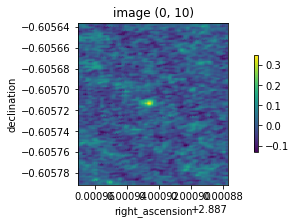

In [36]:
cngi.image.preview(img_xds, variable='image', region=None, pol=0, channels=10, tsize=200)

In [37]:
img_xds.right_ascension

<xarray.DataArray 'right_ascension' (d0: 200, d1: 400)>
dask.array<zarr, shape=(200, 400), dtype=float64, chunksize=(200, 400), chunktype=numpy.ndarray>
Coordinates:
    declination      (d0, d1) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
    right_ascension  (d0, d1) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
Dimensions without coordinates: d0, d1

In [0]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import datetime

In [0]:
# some parsing/conversion necessary due to kooky format in this case
non_weird_time_list = [int(tt) for tt in img_xds.attrs['date_observation'].split('/')[:3]]
obs_date = datetime.datetime(*non_weird_time_list) # parameter expansion

In [67]:
reference_freq_and_unit = img_xds.attrs['rest_frequency'].split(' ')
if 'hz' in reference_freq_and_unit:
  reference_freq_and_unit.append(reference_freq_and_unit.pop().capitalize())
print(' '.join(reference_freq_and_unit))

3.72637e+11 Hz


In [0]:
sc = SkyCoord(frame='icrs', 
         unit=tuple(img_xds.attrs['axisunits'][0:2]),
         obstime=Time(obs_date),
         equinox=img_xds.attrs['direction_reference'],
         representation_type='spherical',
         ra=img_xds.right_ascension.values, # eager __array_like__ objects
         dec=img_xds.declination.values,
         #radial_velocity=u.Quantity(' '.join(reference_freq_and_unit)),
)

In [73]:
print(SkyCoord(img_xds.right_ascension.values, img_xds.declination.values, frame='icrs', unit=u.radian))

<SkyCoord (ICRS): (ra, dec) in deg
    [[(165.46851993, -34.7092683 ), (165.46851993, -34.70924608),
      (165.46851993, -34.70922386), ..., (165.46851964, -34.70044608),
      (165.46851964, -34.70042386), (165.46851964, -34.70040164)],
     [(165.4684929 , -34.7092683 ), (165.4684929 , -34.70924608),
      (165.4684929 , -34.70922386), ..., (165.46849261, -34.70044608),
      (165.46849261, -34.70042386), (165.46849261, -34.70040164)],
     [(165.46846586, -34.7092683 ), (165.46846586, -34.70924608),
      (165.46846586, -34.70922386), ..., (165.46846558, -34.70044608),
      (165.46846558, -34.70042386), (165.46846558, -34.70040164)],
     ...,
     [(165.4631945 , -34.70926831), (165.4631945 , -34.70924608),
      (165.4631945 , -34.70922386), ..., (165.46319478, -34.70044608),
      (165.46319478, -34.70042386), (165.46319478, -34.70040164)],
     [(165.46316747, -34.7092683 ), (165.46316747, -34.70924608),
      (165.46316747, -34.70922386), ..., (165.46316775, -34.70044608),
  

In [84]:
sc.is_transformable_to('FK5')

False

In [74]:
img_xds.attrs

{'axisunits': ['rad', 'rad', '', 'Hz'],
 'date_observation': '2012/11/19/07',
 'direction_reference': 'j2000',
 'imagetype': 'Intensity',
 'object_name': 'tw hya',
 'observer': 'cqi',
 'perplanebeams': [['nChannels', 384],
  ['nStokes', 1],
  ['beams.*0.*0.major.unit', 'arcsec'],
  ['beams.*0.*0.major.value', 0.6534699201583862],
  ['beams.*0.*0.minor.unit', 'arcsec'],
  ['beams.*0.*0.minor.value', 0.5046054124832153],
  ['beams.*0.*0.positionangle.unit', 'deg'],
  ['beams.*0.*0.positionangle.value', -65.90599060058594],
  ['beams.*1.*0.major.unit', 'arcsec'],
  ['beams.*1.*0.major.value', 0.6534699201583862],
  ['beams.*1.*0.minor.unit', 'arcsec'],
  ['beams.*1.*0.minor.value', 0.5046054124832153],
  ['beams.*1.*0.positionangle.unit', 'deg'],
  ['beams.*1.*0.positionangle.value', -65.90599060058594],
  ['beams.*10.*0.major.unit', 'arcsec'],
  ['beams.*10.*0.major.value', 0.6534606218338013],
  ['beams.*10.*0.minor.unit', 'arcsec'],
  ['beams.*10.*0.minor.value', 0.5045977234840393],
 